In [234]:
from __future__ import division
from __future__ import print_function

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

import scipy

import sys
sys.path.append('./modules/')
from Processors import *

In [235]:
loc = './Data/'

energies = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]

signalData = []
backgroundData = []

for energy in energies:
    signalData.append(pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + 
                                      str(energy) + "_narrow_13TeV-madgraph.csv"))

# same as 2 but only the first half of the events
#backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_1.csv"))
backgroundData.append(pandas.read_csv(loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv"))
backgroundData.append(pandas.read_csv(loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"))


# drop columns without header
for signal_data in signalData:
    signal_data.drop([x for x in signal_data.columns if 'Unnamed' in x], axis=1, inplace=True)

for background_data in backgroundData:
    background_data.drop([x for x in background_data.columns if 'Unnamed' in x], axis=1, inplace=True)

allSignalData = signalData[0]
for signal_data in signalData[1:]:
    allSignalData = allSignalData.append(signal_data, ignore_index=True)

allBackgroundData = backgroundData[0]
for background_data in backgroundData[1:]:
    allBackgroundData = allBackgroundData.append(background_data, ignore_index=True)

for i in range(len(energies)):
    print("{} events for Higgs with {} GeV".format(len(signalData[i]), energies[i]))
print("{} TT_Tune events".format(len(backgroundData[0])))
print("{} WJetsToLNu_Tune events".format(len(backgroundData[1])), end='\n\n')
print("{} events of Higgs".format(len(allSignalData)))
print("{} background events".format(len(allBackgroundData)))

403 events for Higgs with 260 GeV
394 events for Higgs with 270 GeV
390 events for Higgs with 280 GeV
372 events for Higgs with 300 GeV
479 events for Higgs with 320 GeV
655 events for Higgs with 400 GeV
1619 events for Higgs with 500 GeV
1858 events for Higgs with 550 GeV
2008 events for Higgs with 600 GeV
2239 events for Higgs with 700 GeV
166157 TT_Tune events
1896 WJetsToLNu_Tune events

10417 events of Higgs
168053 background events


In [236]:
# add column for classification
#allSignalData['gen_classification'] = np.ones(len(allSignalData))
#allBackgroundData['gen_classification'] = np.zeros(len(allBackgroundData))

allData = allSignalData.append(allBackgroundData, ignore_index=True)
allLabels = np.append(np.ones(len(allSignalData)),np.zeros(len(allBackgroundData)))

In [237]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(allData, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(allData, p) #Calculate energy and absolute momentum
    
moveToCartesian(allData, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(allData, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(allData, allData['t_1_pT'], allData['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

## select train variables

In [238]:
genFeatures = [var for var in allData.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in allData.columns if var not in genFeatures] #Reconstructed features; ok for training

In [239]:
pTEtaPhi = [var for var in trainFeatures for x in ['phi', 't_1_mass'] if x in var] # 'pT', 'eta', 
other = [var for var in trainFeatures for x in ['diH_kinFit_prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [240]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']

In [241]:
classTrainFeatures = fsFeatures
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 64 features ['t_0_pT', 't_0_eta', 't_0_mass', 't_1_pT', 't_1_eta', 'b_0_pT', 'b_0_eta', 'b_0_mass', 'b_0_csv', 'b_1_pT', 'b_1_eta', 'b_1_mass', 'b_1_csv', 'mPT_pT', 'h_tt_pT', 'h_tt_eta', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_pT', 'h_bb_eta', 'h_bb_mass', 'diH_pT', 'diH_eta', 'diH_mass', 'diH_kinFit_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


In [242]:
X_train, X_test, y_train, y_test = train_test_split(allData[classTrainFeatures], allLabels, test_size=0.2, random_state=2345)
for var in (X_train, X_test):
    var.reset_index(inplace=True, drop=True)

## Remove points who fail conversion to float32

In [248]:
def cleanData(X, y):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        selecting = selecting | over[label] | under[label]
    
    y = y[np.logical_not(selecting)]#.astype('float32')
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X, y

In [249]:
X_train, y_train = cleanData(X_train, y_train)
X_test , y_test  = cleanData(X_test , y_test )

In [245]:
scale = len(allBackgroundData)/len(allSignalData)

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale
weights_test[y_test == 1] = scale

In [247]:
%%time
# fit model on training data
model = xgb.XGBClassifier(random_state=1337, silent=False,
                          scale_pos_weight=scale,
                          objective='binary:logistic',
                          n_estimators=100, eval_metric='auc',
                          n_jobs=8) #NOTE: number os threads to execute
model.fit(X_train, y_train)

CPU times: user 1min 58s, sys: 316 ms, total: 1min 58s
Wall time: 16.5 s


In [250]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [251]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy           : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=y_test)
print("Accuracy signal    : {:10}%".format(accuracy * 100.0))

accuracy = accuracy_score(y_test, predictions, sample_weight=np.logical_not(y_test))
print("Accuracy background: {:10}%".format(accuracy * 100.0))

Accuracy           : 91.60292510716988%
Accuracy signal    : 91.22807017543859%
Accuracy background: 91.62511870845205%


In [252]:
print(model.score(X_train, y_train, sample_weight=weights_train))
print(model.score(X_test, y_test, sample_weight=weights_test))

0.921286637765
0.914311492549


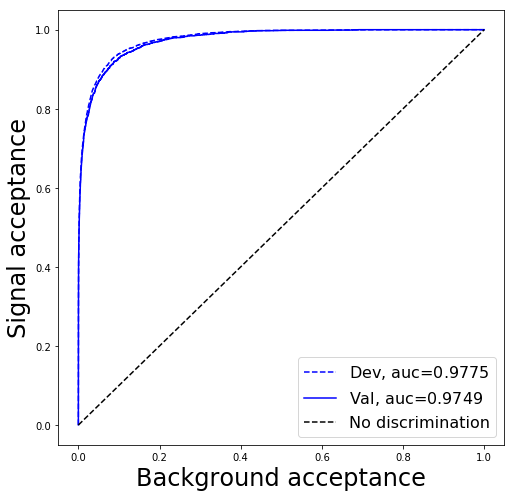

In [254]:
from sklearn import metrics

plt.figure(figsize=[8, 8])
plt.plot(*metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

## sklearn tree

In [94]:
%%time
#clf.predict(X_test)
#clf = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf = ExtraTreesClassifier(n_estimators=100, max_depth=3,
                             random_state=0, class_weight='balanced',
                             max_features=None, n_jobs=-1)

clf = clf.fit(X_train, y_train)

CPU times: user 1min 2s, sys: 72 ms, total: 1min 2s
Wall time: 9.05 s


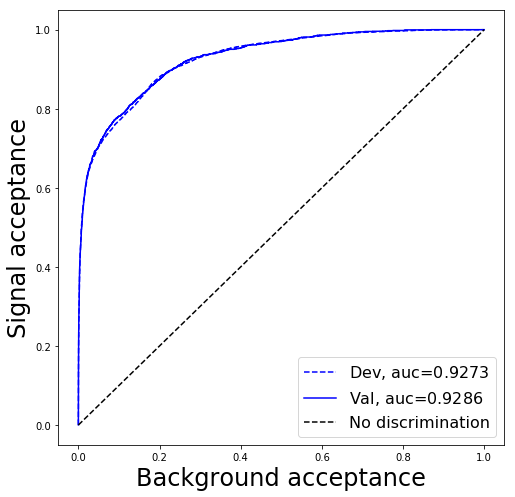

In [95]:
plt.figure(figsize=[8, 8])
plt.plot(*metrics.roc_curve(y_train, clf.predict_proba(X_train)[:,1])[:2],
         label=r'Dev, auc=${:.4f}$'.format(metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])[:2], 
         label=r'Val, auc=${:.4f}$'.format(metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

In [96]:
clf.get_params()

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

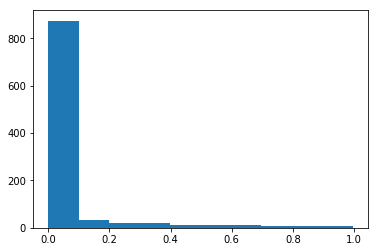

In [97]:
from scipy.stats import rv_continuous
from scipy import log
class one_over_x_gen(rv_continuous):
    def __init__(self, **kargs):
        rv_continuous.__init__(self,**kargs)
        self.log_b_a = log(self.b/self.a)
    """1/x"""
    def _pdf(self, x):
        return 1/x/self.log_b_a

dist = one_over_x_gen(a=1e-8,b=1)

plt.hist(dist.rvs(size=(1000)))
plt.show()

In [103]:
%%time

from sklearn.model_selection import RandomizedSearchCV
asd = RandomizedSearchCV(clf, {'criterion': ['gini', 'entropy'], 'min_impurity_split': dist}, n_iter=50, n_jobs=-1)

asd.fit(X_train, y_train)

CPU times: user 1min 31s, sys: 688 ms, total: 1min 32s
Wall time: 16min 15s


In [104]:
asd.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=0.29610417009783829,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

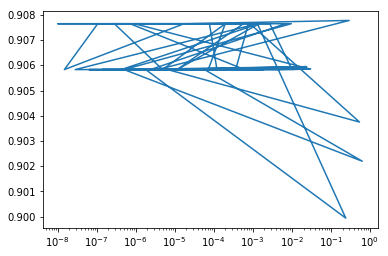

In [121]:
plt.semilogx([x['min_impurity_split'] for x in asd.cv_results_['params']],asd.cv_results_['mean_train_score'])
plt.show()

In [109]:
asd.cv_results_

{'mean_fit_time': array([ 43.3086679 ,  44.9299949 ,  45.52724902,  43.01581311,
         45.03490448,  46.27728184,  41.61823487,  48.53679013,
         47.17735203,  47.32150523,  45.42543356,  50.22864795,
         50.52565368,  48.22877963,  48.75204714,  50.12408328,
         49.11868175,  52.38032095,  49.08683896,  47.67175388,
         48.77292148,  46.96425891,  50.05422004,  50.08247797,
         49.02059738,  49.38897475,  48.54801806,  49.32678588,
         49.59871093,  46.60690157,  48.39980396,  50.53754791,
         47.86342255,  48.70349813,  49.55674561,  45.52718623,
         49.28405992,  48.29807202,  47.92085139,  48.78294381,
         46.75008758,  47.64371324,  48.68487962,  48.57335226,
         48.67336822,  48.19529223,  48.73216263,  50.29421012,
         46.85690419,  28.62254906]),
 'mean_score_time': array([ 0.86591911,  0.79129839,  0.85655443,  0.97100711,  0.85262505,
         0.98801565,  0.92201169,  1.24511115,  0.97464482,  1.21945333,
         1.1

In [123]:
cacaca = np.array([x['criterion'] for x in asd.cv_results_['params']])

In [126]:
asd.cv_results_['mean_test_score'][cacaca == 'gini']

array([ 0.90600266,  0.90595363,  0.90600266,  0.90600266,  0.90600266,
        0.90600266,  0.90035021,  0.90600266,  0.90600266,  0.9060587 ,
        0.90600266,  0.90600266,  0.90600266,  0.90600266,  0.90600266,
        0.90600266,  0.90600266,  0.90600266,  0.90600266,  0.90600266,
        0.90595363,  0.90600266,  0.90600266,  0.90600266,  0.90600266,
        0.90600266,  0.90600266,  0.90600266,  0.90600266])

In [127]:
asd.cv_results_['mean_test_score'][cacaca != 'gini']

array([ 0.90781677,  0.90781677,  0.90217132,  0.90781677,  0.90781677,
        0.90781677,  0.90781677,  0.90781677,  0.90781677,  0.90781677,
        0.90781677,  0.90781677,  0.90781677,  0.90781677,  0.90384535,
        0.90785879,  0.90781677,  0.90781677,  0.90781677,  0.90781677,
        0.90781677])

In [74]:
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=5,
                                feature_names=X_train.columns, 
                                class_names=["background", "signal"],
                                filled=True, rounded=True,
                                special_characters=True)


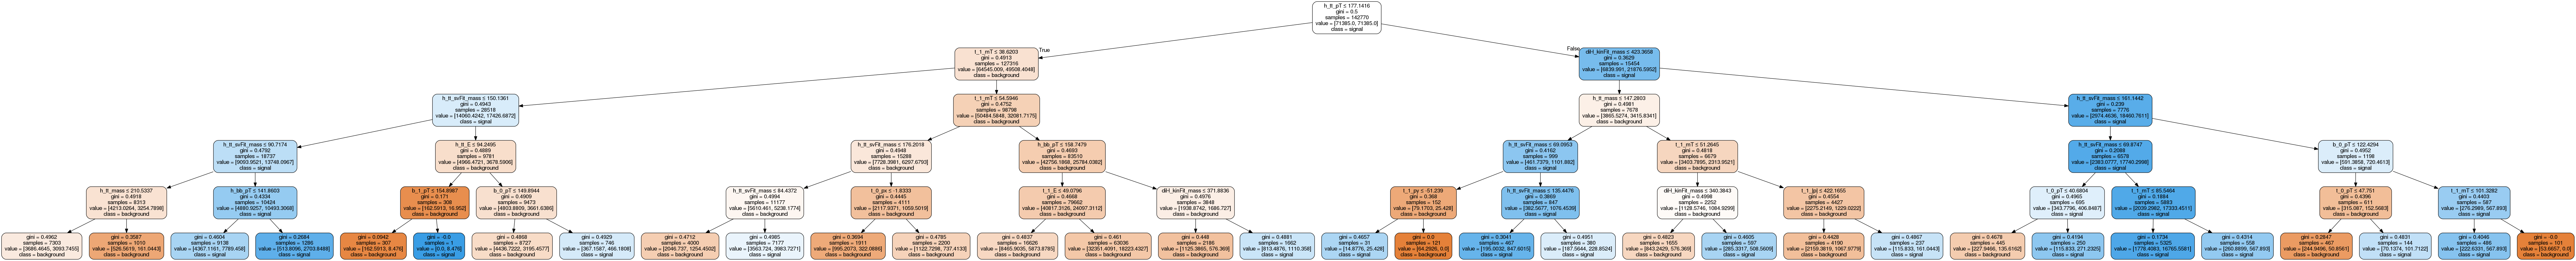

In [75]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [30]:
from sklearn import tree
from sklearn import metrics

clf = tree.DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=0)
tree_score = cross_val_score(clf, X_train, y_train, cv=10, verbose=1, n_jobs=-1,
                             scoring=metrics.make_scorer(metrics.roc_auc_score))

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.1s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.1s finished


In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=5,
                             random_state=0, class_weight='balanced')
RFC_score = cross_val_score(clf, X_train, y_train, cv=10, verbose=1, n_jobs=-1,
                            scoring=metrics.make_scorer(metrics.roc_auc_score))

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.0s finished


In [35]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=100, max_depth=3,
                           random_state=0, class_weight='balanced')
ETC_score = cross_val_score(clf, X_train, y_train, cv=10, verbose=1, n_jobs=-1,
                            scoring=metrics.make_scorer(metrics.roc_auc_score))

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   11.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.1s finished


In [33]:
print("tree: {:0.3f}(+/-{:0.3f})".format(tree_score.mean(), tree_score.std()))
print("RFC : {:0.3f}(+/-{:0.3f})".format(RFC_score.mean(), RFC_score.std()))
print("ETC : {:0.3f}(+/-{:0.3f})".format(ETC_score.mean(), ETC_score.std()))

tree: 0.880(+/-0.005)
RFC : 0.862(+/-0.006)
ETC : 0.807(+/-0.008)


In [39]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=1337, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=16.132571757703754, seed=None,
       silent=False, subsample=1)

### shit

In [258]:
def func(gamma):
    # fit model on training data
    model = xgb.XGBClassifier(random_state=1337, silent=False, scale_pos_weight=scale, objective='binary:logistic',n_estimators=300 , eval_metric='auc', gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [262]:
from bayes_opt import BayesianOptimization

bo = BayesianOptimization(func,
                          {'gamma': (0, .5)})

bo.explore({'gamma': [0, .2]})

#bo.initialize(
#        {'target': [0.5, 1],
#         'h_bb_mass_avg': [100, 120], 'h_bb_mass_std': [30, 40],
#         'h_tt_mass_avg': [95 , 115], 'h_tt_mass_std': [40, 55]}
#)

bo.maximize(init_points=1, n_iter=5, kappa=2)

print(bo.res['max'])

Initialization
-----------------------------------------
 Step |   Time |      Value |     gamma | 
    1 | 02m35s |    0.93259 |    0.0000 | 
    2 | 02m35s |    0.93259 |    0.2000 | 
    3 | 02m35s |    0.93315 |    0.3924 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'warnflag': 2, 'funcalls': 45, 'grad': array([ -5.50908657e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     gamma | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'warnflag': 2, 'funcalls': 52, 'grad': array([  5.94484499e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    4 | 02m37s |    0.93315 |    0.4994 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'warnflag': 2, 'funcalls': 49, 'grad': array([ -1.12287137e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 7, 'warnflag': 2, 'funcalls': 60, 'grad': array([  2.00804566e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


    5 | 02m32s |    0.93315 |    0.4405 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'warnflag': 2, 'funcalls': 78, 'grad': array([-0.00080148])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'warnflag': 2, 'funcalls': 55, 'grad': array([ 0.00074283])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 7, 'warnflag': 2, 'funcalls': 76, 'grad': array([ -6.66595759e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnor

    6 | 02m41s |    0.93315 |    0.4133 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'warnflag': 2, 'funcalls': 54, 'grad': array([ -2.68466974e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 7, 'warnflag': 2, 'funcalls': 76, 'grad': array([ -1.09093344e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'warnflag': 2, 'funcalls': 56, 'grad': array([ 0.00030673])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated 

    7 | 02m34s |    0.93315 |    0.4933 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 6, 'warnflag': 2, 'funcalls': 85, 'grad': array([-0.0011128])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'warnflag': 2, 'funcalls': 46, 'grad': array([ -1.51877707e-05])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'warnflag': 2, 'funcalls': 53, 'grad': array([-0.00287261])}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnorm

    8 | 02m46s |    0.93315 |    0.4616 | 
{'max_val': 0.93315403148988629, 'max_params': {'gamma': 0.39238907284287555}}
